# Sentiment Analysis on Movie Reviews

Using multiple architectures to perform sentiment analysis on the IMDB dataset. The dataset consists of 50,000 reviews from IMDB, labeled by sentiment (positive/negative). The dataset is divided into 25,000 reviews for training and 25,000 reviews for testing. The goal is to build a model that can predict the sentiment of a review with high accuracy.

The following architectures will be used:
1. RNN
2. LSTM
3. GRU
4. Bidirectional RNN
5. Bidirectional LSTM
6. Bidirectional GRU
7. Convolutional Neural Network (CNN)

The models will be trained on the training set and evaluated on the testing set. The model with the highest accuracy on the testing set will be selected as the best model for sentiment analysis on movie reviews.

In [1]:
import sys
sys.path.append('/kaggle/input/sentiment-analysis-utils')
!mkdir -p weights # For storing the weights

import torch
import string
import pandas as pd
from collections import Counter

from utils import EarlyStopping, Utils
from model import SentimentAnalyzer

from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download and load the IMDb dataset
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
# convert DatasetDict to a pandas dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

print(df_train.shape, df_test.shape)
df_train.head(3)

(25000, 2) (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0


# Preprocessing and Tokenization

In [3]:
# Tokenize the reviews
df_train['text'] = df_train['text'].apply(word_tokenize)
df_test['text'] = df_test['text'].apply(word_tokenize)

# Lowercase the reviews
df_train['text'] = df_train['text'].apply(lambda x: [s.lower() for s in x])
df_test['text'] = df_test['text'].apply(lambda x: [s.lower() for s in x])

# Remove html tags
tags = ['<', '>', 'br', '/', '``', "''", '...']
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if not s.startswith('<') and not s.endswith('>') and s not in tags])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if not s.startswith('<') and not s.endswith('>') and s not in tags])

# Remove punctuation like '!', '?', etc.
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s not in string.punctuation])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s not in string.punctuation])

# Remove stopwords like 'and', 'the', 'a', etc.
stop_words = set(stopwords.words('english'))
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s not in stop_words])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s not in stop_words])

# Remove numbers
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if not s.isdigit()])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if not s.isdigit()])

# Remove empty strings
df_train['text'] = df_train['text'].apply(lambda x: [s for s in x if s])
df_test['text'] = df_test['text'].apply(lambda x: [s for s in x if s])

# Add 10K rows to the training set from the test set
df_train, df_test = pd.concat([df_train, df_test.sample(10000, random_state=0)]).reset_index(drop=True), df_test.drop(df_test.sample(10000, random_state=0).index).reset_index(drop=True)

# Shuffle the dataset
df_train = df_train.sample(frac=1, random_state=0).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=0).reset_index(drop=True)

# Get the max/min length of the reviews
max_len = df_train['text'].apply(len).max()
min_len = df_train['text'].apply(len).min()
avg_len = df_train['text'].apply(len).mean().round()

print(f'Max length: {max_len}, Min length: {min_len}, Avg length: {avg_len}')

# Quick look at the processed data
display(df_train.head(3))

df_train.shape, df_test.shape

Max length: 1450, Min length: 4, Avg length: 123.0


,text,label
0,"[far, racist, ghettoish, cartoon, children, 7+...",0
1,"[one, worst, movies, 've, ever, seen, 'm, stil...",0
2,"[thin, story, many, fine, shots, eyecatchers, ...",1


((35000, 2), (15000, 2))

<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

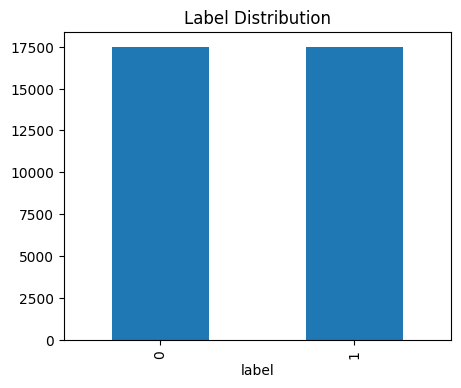

In [4]:
# Check label distribution
df_train['label'].value_counts().plot(kind='bar', title='Label Distribution', figsize=(5, 4))

# Vocabulary Creation
vocab creation is the first step in the text processing pipeline. It is the process of extracting unique words from the text and assigning an index to each word. The vocabulary is used to convert the text into a numerical representation that can be used as input to machine learning models.

In [5]:
# Copy for future use
df_train_preprocessed, df_test_preprocessed = df_train.copy(), df_test.copy()

In [6]:
# Create a vocabulary
vocab = set()
for review in df_train['text']:
    vocab.update(review)
for review in df_test['text']:
    vocab.update(review)

print('Vocab Size:', len(list(vocab)))

Vocab Size: 167654


Since the vocabulary is huge, we will only keep the most 20K frequent words, after that we will replace the rest with `<UNK>`

In [7]:
word_freq = Counter()

for review in df_train['text']:
    word_freq.update(review)
for review in df_test['text']:
    word_freq.update(review)

# Create a vocabulary
vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_freq.most_common(20_000)] # <PAD> is for padding to tell the embedding layer to ignore it, <UNK> is for unknown words

print(len(vocab))

20002


Convert the text into sequences of integers using the vocabulary. Each word in the text is replaced by its corresponding index in the vocabulary.

In [8]:
max_len = 300 # Maximum length of words in a review (context window)

# Create a word to index mapping
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Convert the reviews to indices
df_train['text'] = df_train['text'].apply(lambda x: [word_to_idx.get(word, 1) for word in x]) # 1 is the index of '<UNK>' token
df_test['text'] = df_test['text'].apply(lambda x: [word_to_idx.get(word, 1) for word in x])

# Truncate and pad the reviews
df_train['text'] = df_train['text'].apply(lambda x: x[:max_len] if len(x) > max_len else x + [0] * (max_len - len(x))) # Pad with zeros as the index of '<PAD>' is 0
df_test['text'] = df_test['text'].apply(lambda x: x[:max_len] if len(x) > max_len else x + [0] * (max_len - len(x)))

# print the first 3 reviews
display(df_train.head(3), df_train_preprocessed.head(3))

# Split test set into validation and test sets
df_val = df_test.sample(frac=0.5)
df_test = df_test.drop(df_val.index)

# Convert data to lists
X_train, y_train = df_train['text'].tolist(), df_train['label'].tolist()
X_val, y_val = df_val['text'].tolist(), df_val['label'].tolist()
X_test, y_test = df_test['text'].tolist(), df_test['label'].tolist()

,text,label
0,"[126, 2621, 1, 917, 290, 1, 230, 30, 917, 1084...",0
1,"[6, 142, 27, 54, 45, 34, 57, 48, 144, 462, 189...",0
2,"[1576, 14, 33, 361, 506, 1, 176, 1891, 1, 586,...",1


,text,label
0,"[far, racist, ghettoish, cartoon, children, 7+...",0
1,"[one, worst, movies, 've, ever, seen, 'm, stil...",0
2,"[thin, story, many, fine, shots, eyecatchers, ...",1


# **Training Phase**

## RNN Model (Unidirectional)

In [9]:
# Same Parameters for all models
embedding_dim = 128
batch_size = 1024
hidden_dim = 256
dropout = 0.3
n_layers = 2
lr = 1e-3

model_rnn = SentimentAnalyzer(model_type='rnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/rnn.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_rnn.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 2,790,913


In [10]:
history_rnn = model_rnn.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.7356 - Val Loss: 0.7122 - Acc: 0.5119 - F1: 0.3687 - Precision: 0.5258 - Recall: 0.2839 - lr: 0.001


Epoch 2/12 - Train Loss: 0.7391 - Val Loss: 0.7802 - Acc: 0.4916 - F1: 0.5982 - Precision: 0.4959 - Recall: 0.7536 - lr: 0.001


Epoch 3/12 - Train Loss: 0.7349 - Val Loss: 0.7129 - Acc: 0.5016 - F1: 0.6403 - Precision: 0.5021 - Recall: 0.8834 - lr: 0.001


Epoch 4/12 - Train Loss: 0.7085 - Val Loss: 0.7296 - Acc: 0.5029 - F1: 0.6443 - Precision: 0.5028 - Recall: 0.8967 - lr: 0.0001


Epoch 5/12 - Train Loss: 0.7046 - Val Loss: 0.6937 - Acc: 0.5017 - F1: 0.2950 - Precision: 0.5094 - Recall: 0.2076 - lr: 0.0001


Epoch 6/12 - Train Loss: 0.6994 - Val Loss: 0.6951 - Acc: 0.4953 - F1: 0.5763 - Precision: 0.4982 - Recall: 0.6835 - lr: 0.0001


Epoch 7/12 - Train Loss: 0.7003 - Val Loss: 0.6937 - Acc: 0.5039 - F1: 0.6090 - Precision: 0.5039 - Recall: 0.7695 - lr: 0.0001


Epoch 8/12 - Train Loss: 0.6990 - Val Loss: 0.6936 - Acc: 0.4985 - F1: 0.6105 - Precision: 0.5004 - Recall: 0.7828 - lr: 0.0001


Epoch 9/12 - Train Loss: 0.6987 - Val Loss: 0.6937 - Acc: 0.5100 - F1: 0.3625 - Precision: 0.5228 - Recall: 0.2775 - lr: 0.0001


Epoch 10/12 - Train Loss: 0.6981 - Val Loss: 0.6967 - Acc: 0.5013 - F1: 0.6347 - Precision: 0.5020 - Recall: 0.8627 - lr: 0.0001
Early stopping...


In [11]:
# evaluate the model
loss, acc, f1, precision, recall = model_rnn.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.6964, Accuracy: 0.4997, F1: 0.6328, Precision: 0.4994, Recall: 0.8635


## RNN Model (Bidirectional)

In [12]:
model_rnn_bi = SentimentAnalyzer(model_type='rnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True, # Bidirectional
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/rnn_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_rnn_bi.optimizer, mode='min', factor=0.1, patience=3) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,152,641


In [13]:
# Train the model
history_rnn_bi = model_rnn_bi.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.9767 - Val Loss: 0.8200 - Acc: 0.5137 - F1: 0.6625 - Precision: 0.5085 - Recall: 0.9503 - lr: 0.001


Epoch 2/12 - Train Loss: 0.8985 - Val Loss: 0.7529 - Acc: 0.5068 - F1: 0.0989 - Precision: 0.5988 - Recall: 0.0539 - lr: 0.001


Epoch 3/12 - Train Loss: 0.7675 - Val Loss: 0.7030 - Acc: 0.5059 - F1: 0.5214 - Precision: 0.5075 - Recall: 0.5361 - lr: 0.001


Epoch 4/12 - Train Loss: 0.7096 - Val Loss: 0.7810 - Acc: 0.4979 - F1: 0.0000 - Precision: 0.0000 - Recall: 0.0000 - lr: 0.001


Epoch 5/12 - Train Loss: 0.7016 - Val Loss: 0.7034 - Acc: 0.5004 - F1: 0.5490 - Precision: 0.5021 - Recall: 0.6057 - lr: 0.001


Epoch 6/12 - Train Loss: 0.6847 - Val Loss: 0.7909 - Acc: 0.5045 - F1: 0.6674 - Precision: 0.5034 - Recall: 0.9899 - lr: 0.001


Epoch 7/12 - Train Loss: 0.6928 - Val Loss: 0.7469 - Acc: 0.5491 - F1: 0.5269 - Precision: 0.5568 - Recall: 0.5000 - lr: 0.0001


Epoch 8/12 - Train Loss: 0.6596 - Val Loss: 0.6855 - Acc: 0.5559 - F1: 0.5453 - Precision: 0.5611 - Recall: 0.5303 - lr: 0.0001


Epoch 9/12 - Train Loss: 0.6327 - Val Loss: 0.6984 - Acc: 0.5565 - F1: 0.5244 - Precision: 0.5682 - Recall: 0.4870 - lr: 0.0001


Epoch 10/12 - Train Loss: 0.6380 - Val Loss: 0.7307 - Acc: 0.5507 - F1: 0.4094 - Precision: 0.6021 - Recall: 0.3101 - lr: 0.0001


Epoch 11/12 - Train Loss: 0.6248 - Val Loss: 0.7001 - Acc: 0.5555 - F1: 0.5074 - Precision: 0.5720 - Recall: 0.4559 - lr: 0.0001


Epoch 12/12 - Train Loss: 0.6206 - Val Loss: 0.6981 - Acc: 0.5531 - F1: 0.5021 - Precision: 0.5698 - Recall: 0.4488 - lr: 1e-05


In [14]:
# evaluate the model
loss, acc, f1, precision, recall = model_rnn_bi.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.6916, Accuracy: 0.5617, F1: 0.5548, Precision: 0.5628, Recall: 0.5470


## LSTM Model (Unidirectional)

In [15]:
model_lstm = SentimentAnalyzer(model_type='lstm',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/lstm.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_lstm.optimizer, mode='min', factor=0.1, patience=1) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,482,113


In [16]:
history_lstm = model_lstm.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.7256 - Val Loss: 0.6939 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.001


Epoch 2/12 - Train Loss: 0.6942 - Val Loss: 0.6933 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.001


Epoch 3/12 - Train Loss: 0.6940 - Val Loss: 0.6935 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.001


Epoch 4/12 - Train Loss: 0.6943 - Val Loss: 0.6936 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.0001


Epoch 5/12 - Train Loss: 0.6936 - Val Loss: 0.6932 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.0001


Epoch 6/12 - Train Loss: 0.6933 - Val Loss: 0.6931 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.0001
Early stopping...


In [17]:
# evaluate the model
loss, acc, f1, precision, recall = model_lstm.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.6932, Accuracy: 0.4992, F1: 0.6660, Precision: 0.4992, Recall: 1.0000


## LSTM Model (Bidirectional)

In [18]:
model_lstm_bi = SentimentAnalyzer(model_type='lstm',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True, # Bidirectional LSTM
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/lstm_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_lstm_bi.optimizer, mode='min', factor=0.1, patience=1) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 4,928,257


In [19]:
history_lstm_bi = model_lstm_bi.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.7404 - Val Loss: 0.6931 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.001


Epoch 2/12 - Train Loss: 0.6928 - Val Loss: 0.6896 - Acc: 0.5239 - F1: 0.1146 - Precision: 0.8652 - Recall: 0.0613 - lr: 0.001


Epoch 3/12 - Train Loss: 0.7007 - Val Loss: 0.7500 - Acc: 0.4979 - F1: 0.0000 - Precision: 0.0000 - Recall: 0.0000 - lr: 0.001


Epoch 4/12 - Train Loss: 0.6555 - Val Loss: 0.5664 - Acc: 0.7141 - F1: 0.7440 - Precision: 0.6759 - Recall: 0.8274 - lr: 0.001


Epoch 5/12 - Train Loss: 0.4966 - Val Loss: 0.5380 - Acc: 0.7403 - F1: 0.7587 - Precision: 0.7110 - Recall: 0.8133 - lr: 0.001


Epoch 6/12 - Train Loss: 0.3593 - Val Loss: 0.5362 - Acc: 0.7740 - F1: 0.7918 - Precision: 0.7366 - Recall: 0.8561 - lr: 0.001


Epoch 7/12 - Train Loss: 0.3410 - Val Loss: 0.6156 - Acc: 0.7489 - F1: 0.7303 - Precision: 0.7927 - Recall: 0.6771 - lr: 0.001


Epoch 8/12 - Train Loss: 0.2907 - Val Loss: 0.6515 - Acc: 0.7681 - F1: 0.7471 - Precision: 0.8260 - Recall: 0.6819 - lr: 0.0001


Epoch 9/12 - Train Loss: 0.2332 - Val Loss: 0.4579 - Acc: 0.7901 - F1: 0.7747 - Precision: 0.8404 - Recall: 0.7185 - lr: 0.0001


Epoch 10/12 - Train Loss: 0.2050 - Val Loss: 0.4963 - Acc: 0.8043 - F1: 0.7977 - Precision: 0.8290 - Recall: 0.7687 - lr: 0.0001


Epoch 11/12 - Train Loss: 0.1844 - Val Loss: 0.4852 - Acc: 0.8143 - F1: 0.8128 - Precision: 0.8229 - Recall: 0.8030 - lr: 1e-05


Epoch 12/12 - Train Loss: 0.1712 - Val Loss: 0.4795 - Acc: 0.8112 - F1: 0.8098 - Precision: 0.8195 - Recall: 0.8003 - lr: 1e-05


In [20]:
# evaluate the model
loss, acc, f1, precision, recall = model_lstm_bi.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.4550, Accuracy: 0.8264, F1: 0.8275, Precision: 0.8208, Recall: 0.8344


## GRU Model (Unidirectional)

In [21]:
model_gru = SentimentAnalyzer(model_type='gru',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=False,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/gru.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_gru.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 3,251,713


In [22]:
history_gru = model_gru.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.6936 - Val Loss: 0.6929 - Acc: 0.5021 - F1: 0.6686 - Precision: 0.5021 - Recall: 1.0000 - lr: 0.001


Epoch 2/12 - Train Loss: 0.6920 - Val Loss: 0.6926 - Acc: 0.5071 - F1: 0.1089 - Precision: 0.5901 - Recall: 0.0600 - lr: 0.001


Epoch 3/12 - Train Loss: 0.6786 - Val Loss: 0.7075 - Acc: 0.5033 - F1: 0.6637 - Precision: 0.5028 - Recall: 0.9761 - lr: 0.001


Epoch 4/12 - Train Loss: 1.2347 - Val Loss: 0.7057 - Acc: 0.5059 - F1: 0.0753 - Precision: 0.6240 - Recall: 0.0401 - lr: 0.001


Epoch 5/12 - Train Loss: 0.6601 - Val Loss: 0.7151 - Acc: 0.5049 - F1: 0.6640 - Precision: 0.5036 - Recall: 0.9740 - lr: 0.0001


Epoch 6/12 - Train Loss: 0.6507 - Val Loss: 0.7212 - Acc: 0.5071 - F1: 0.6644 - Precision: 0.5048 - Recall: 0.9719 - lr: 0.0001
Early stopping...


In [23]:
# evaluate the model
loss, acc, f1, precision, recall = model_gru.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.7229, Accuracy: 0.5055, F1: 0.6621, Precision: 0.5024, Recall: 0.9706


## GRU Model (Bidirectional)

In [24]:
model_gru_bi = SentimentAnalyzer(model_type='gru',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            bidirectional=True,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/gru_bi.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_gru_bi.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 4,336,385


In [25]:
history_gru_bi = model_gru_bi.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.6381 - Val Loss: 0.5192 - Acc: 0.7373 - F1: 0.7147 - Precision: 0.7860 - Recall: 0.6553 - lr: 0.001


Epoch 2/12 - Train Loss: 0.3736 - Val Loss: 0.3714 - Acc: 0.8325 - F1: 0.8497 - Precision: 0.7735 - Recall: 0.9424 - lr: 0.001


Epoch 3/12 - Train Loss: 0.4282 - Val Loss: 0.5554 - Acc: 0.7881 - F1: 0.7466 - Precision: 0.9345 - Recall: 0.6216 - lr: 0.001


Epoch 4/12 - Train Loss: 0.2414 - Val Loss: 0.4269 - Acc: 0.8353 - F1: 0.8396 - Precision: 0.8216 - Recall: 0.8585 - lr: 0.001


Epoch 5/12 - Train Loss: 0.1798 - Val Loss: 0.4667 - Acc: 0.8349 - F1: 0.8401 - Precision: 0.8181 - Recall: 0.8633 - lr: 0.0001


Epoch 6/12 - Train Loss: 0.1274 - Val Loss: 0.4553 - Acc: 0.8415 - F1: 0.8404 - Precision: 0.8497 - Recall: 0.8314 - lr: 0.0001


Epoch 7/12 - Train Loss: 0.1170 - Val Loss: 0.4630 - Acc: 0.8428 - F1: 0.8420 - Precision: 0.8499 - Recall: 0.8343 - lr: 0.0001
Early stopping...


In [26]:
# evaluate the model
loss, acc, f1, precision, recall = model_gru_bi.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.4253, Accuracy: 0.8572, F1: 0.8568, Precision: 0.8576, Recall: 0.8560


## CNN Model

In [27]:
model_cnn = SentimentAnalyzer(model_type='cnn',
                            vocab_size=len(vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim//2,
                            dropout=dropout,
                            pad_idx=0,
                            n_layers=n_layers,
                            lr=lr,
                            verbose=True,
                            gpu=True)

early_stopping = EarlyStopping(patience=5, delta=0.01, path='weights/cnn.pth') # early stops after 3 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_cnn.optimizer, mode='min', factor=0.1, patience=2) # reduces learning rate by factor of 0.1 when no improvement is seen

SentimentAnalyzer(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (conv1): Conv1d(128, 42, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(42, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=4480, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCELoss()
) 
Running on:  cuda
Number of parameters: 2,613,739


In [28]:
history_cnn = model_cnn.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=batch_size,
                        val_data=(X_val, y_val),
                        early_stopping=early_stopping,
                        scheduler=scheduler
                        )

Epoch 1/12 - Train Loss: 0.6868 - Val Loss: 0.6457 - Acc: 0.7173 - F1: 0.7192 - Precision: 0.7175 - Recall: 0.7209 - lr: 0.001


Epoch 2/12 - Train Loss: 0.3885 - Val Loss: 0.3174 - Acc: 0.8689 - F1: 0.8776 - Precision: 0.8261 - Recall: 0.9360 - lr: 0.001


Epoch 3/12 - Train Loss: 0.1719 - Val Loss: 0.3184 - Acc: 0.8784 - F1: 0.8848 - Precision: 0.8439 - Recall: 0.9299 - lr: 0.001


Epoch 4/12 - Train Loss: 0.1069 - Val Loss: 0.6353 - Acc: 0.8105 - F1: 0.7768 - Precision: 0.9508 - Recall: 0.6567 - lr: 0.001


Epoch 5/12 - Train Loss: 0.1139 - Val Loss: 0.3683 - Acc: 0.8769 - F1: 0.8811 - Precision: 0.8558 - Recall: 0.9079 - lr: 0.0001


Epoch 6/12 - Train Loss: 0.0423 - Val Loss: 0.3658 - Acc: 0.8789 - F1: 0.8799 - Precision: 0.8764 - Recall: 0.8834 - lr: 0.0001


Epoch 7/12 - Train Loss: 0.0385 - Val Loss: 0.3713 - Acc: 0.8801 - F1: 0.8807 - Precision: 0.8801 - Recall: 0.8813 - lr: 0.0001
Early stopping...


In [29]:
# evaluate the model
loss, acc, f1, precision, recall = model_cnn.evaluate((X_test, y_test), batch_size=256)
print(f'Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

Loss: 0.3421, Accuracy: 0.8869, F1: 0.8870, Precision: 0.8851, Recall: 0.8889


# Testing

In [30]:
txt_0 = 'The movie wasn\'t too bad after all. I loved it a lot.' # positive
txt_1 = 'The movie, acting, and actors were terrible. I hated it.' # negative

# Preprocess the text
txt_0 = Utils.tokenize_and_preprocess(txt_0, word_to_idx, max_len)
txt_1 = Utils.tokenize_and_preprocess(txt_1, word_to_idx, max_len)

# Get the predictions
for i, model in enumerate([model_rnn, model_rnn_bi, model_lstm, model_lstm_bi, model_gru, model_gru_bi, model_cnn]):
        pred_0 = model.predict([txt_0])
        pred_1 = model.predict([txt_1])

        bi_label = '(BI)' if i % 2 != 0 else ''
        print(f'{model.model_type.upper()} {bi_label}:\nText 0: {round(pred_0.item(), 4)} Text 1: {round(pred_1.item(), 4)}\n')

RNN :
Text 0: 0.5516 Text 1: 0.5524

RNN (BI):
Text 0: 0.4686 Text 1: 0.5048

LSTM :
Text 0: 0.5036 Text 1: 0.5036

LSTM (BI):
Text 0: 0.9745 Text 1: 0.0656

GRU :
Text 0: 0.5007 Text 1: 0.5007

GRU (BI):
Text 0: 0.9396 Text 1: 0.0448

CNN :
Text 0: 0.7386 Text 1: 0.279



# Comparison

- Plots

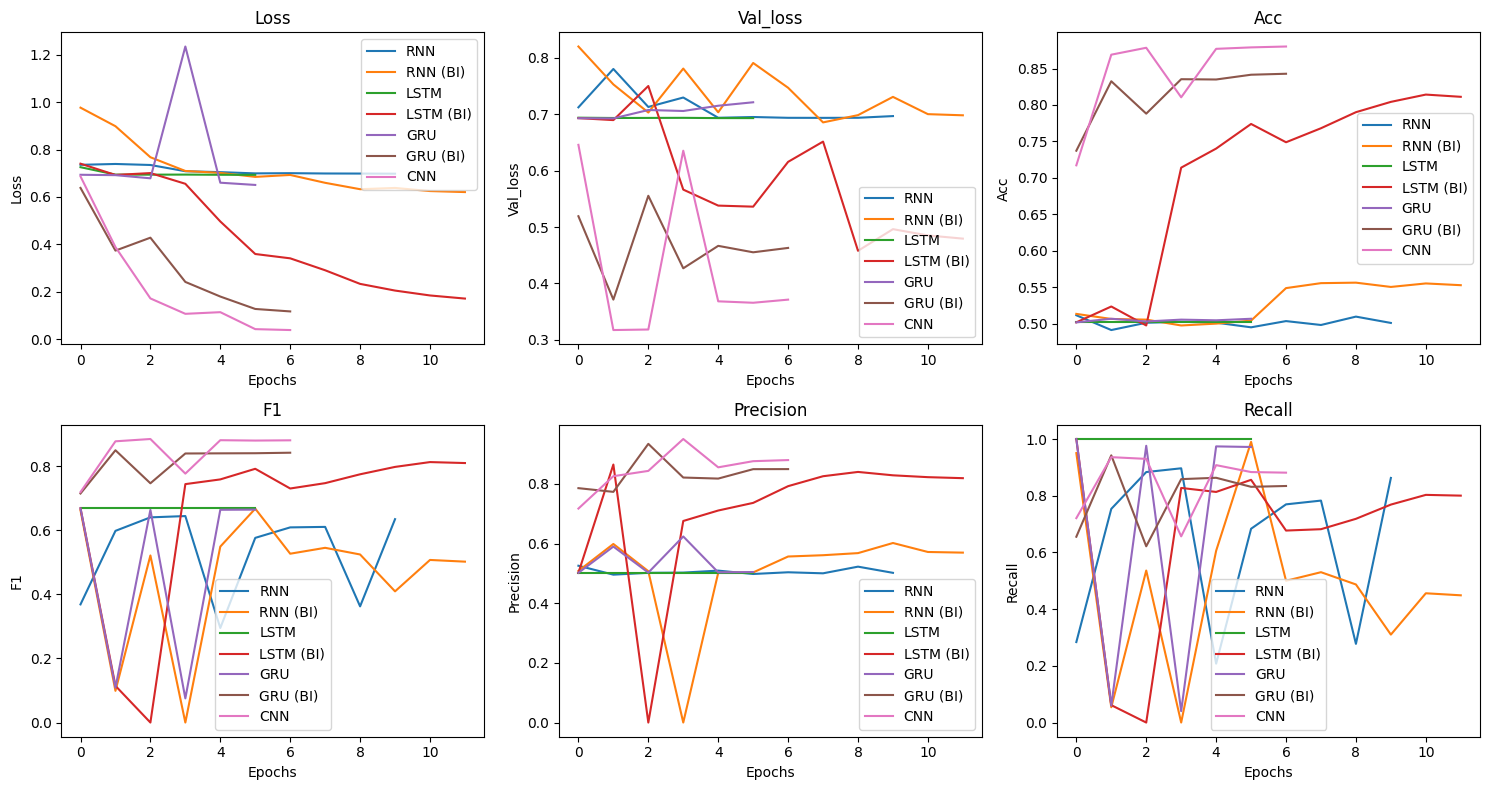

In [31]:
histories = {
    'RNN': history_rnn,
    'RNN (BI)': history_rnn_bi,
    'LSTM': history_lstm,
    'LSTM (BI)': history_lstm_bi,
    'GRU': history_gru,
    'GRU (BI)': history_gru_bi,
    'CNN': history_cnn
}

Utils.plot_training_history(histories)

- Confusion Matrix

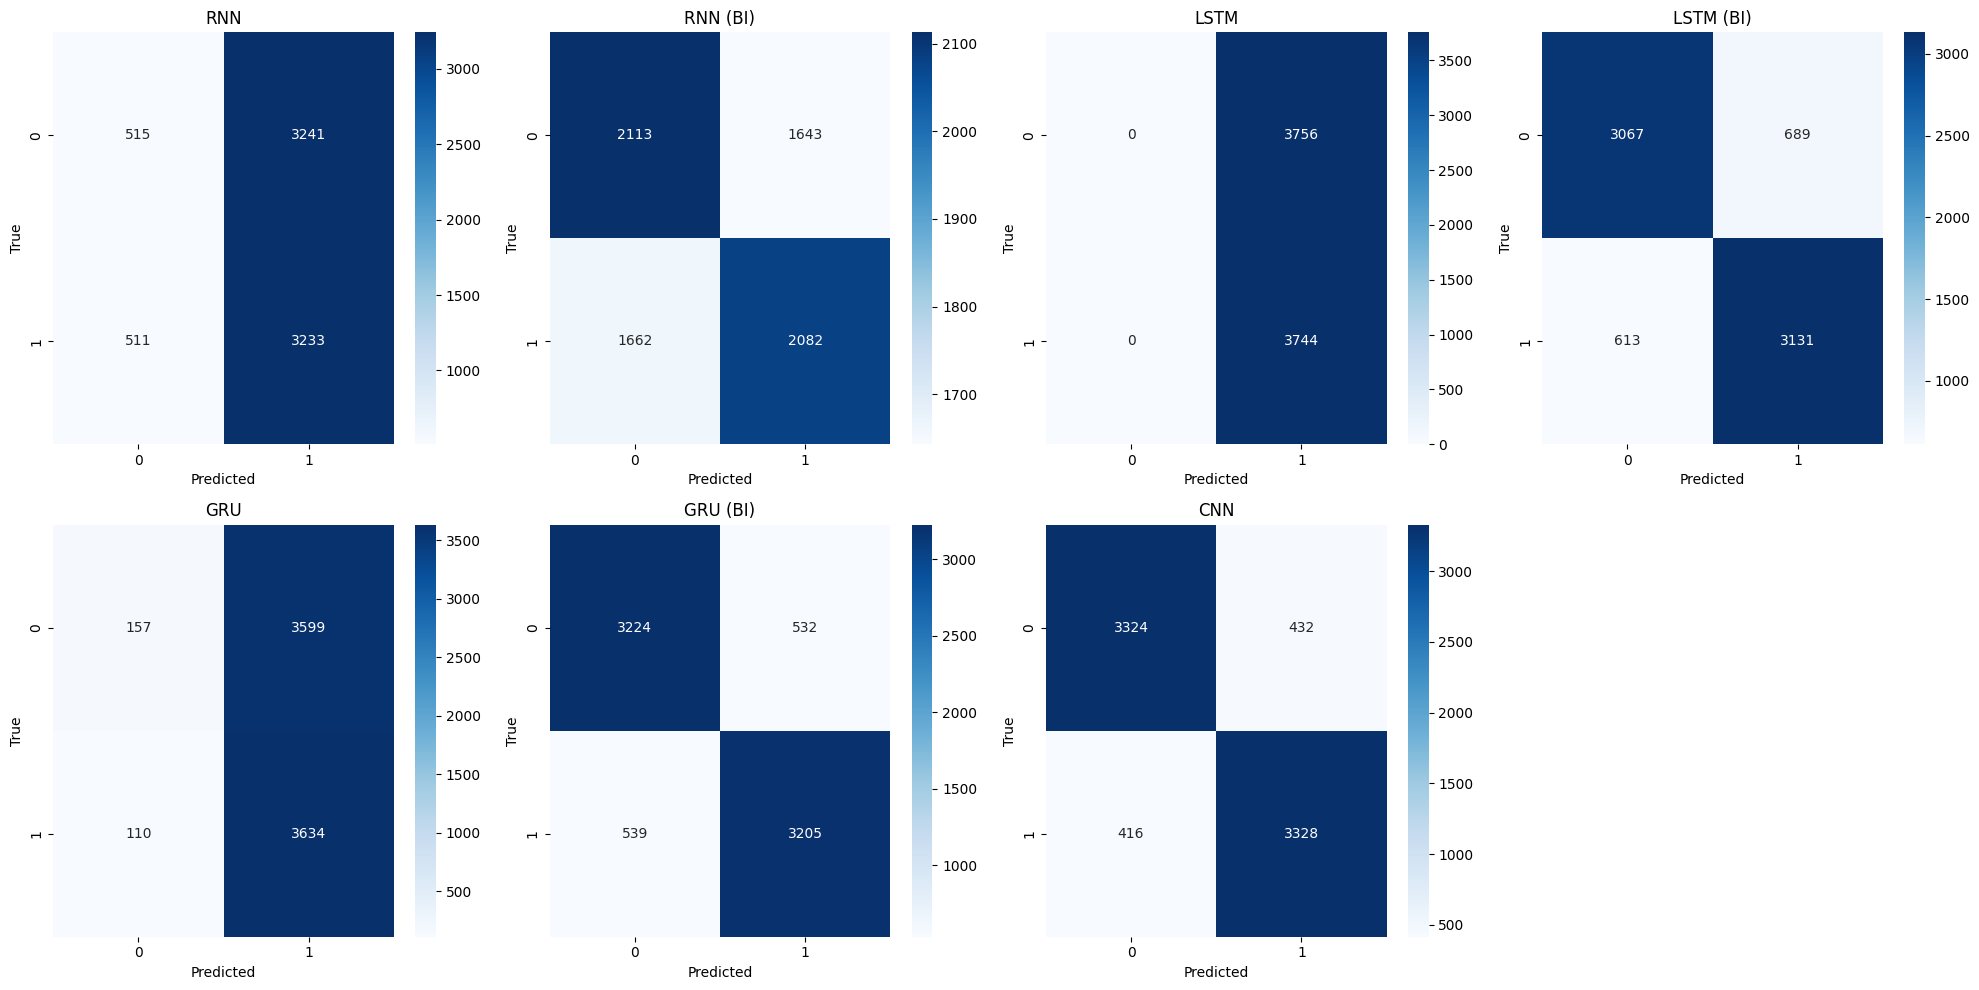

In [32]:
# Get predictions
y_pred_rnn, y_pred_rnn_bi, y_pred_lstm, y_pred_lstm_bi, y_pred_gru, y_pred_gru_bi, y_pred_cnn = model_rnn.predict(X_test), model_rnn_bi.predict(X_test), model_lstm.predict(X_test), model_lstm_bi.predict(X_test), model_gru.predict(X_test), model_gru_bi.predict(X_test), model_cnn.predict(X_test)

models_preds = {
        'RNN': y_pred_rnn,
        'RNN (BI)': y_pred_rnn_bi,
        'LSTM': y_pred_lstm,
        'LSTM (BI)': y_pred_lstm_bi,
        'GRU': y_pred_gru,
        'GRU (BI)': y_pred_gru_bi,
        'CNN': y_pred_cnn
}

# Plot the confusion matrix
Utils.plot_confusion_matrices(y_test, models_preds)

- Comparison Table

In [33]:
models = {
    'RNN': model_rnn,
    'RNN (BI)': model_rnn_bi,
    'LSTM': model_lstm,
    'LSTM (BI)': model_lstm_bi,
    'GRU': model_gru,
    'GRU (BI)': model_gru_bi,
    'CNN': model_cnn
}

Utils.generate_comparison_table(histories,
                                models=models)

+-----------+------------+----------+----------+-----------+----------+--------+--------------------+---------------------+-------------------+------------+
|   Model   | Train Loss | Val Loss | Accuracy | Precision | F1-Score | Recall | Time per Epoch (s) | Training Time (Min) | Memory Usage (MB) | Parameters |
+-----------+------------+----------+----------+-----------+----------+--------+--------------------+---------------------+-------------------+------------+
|    CNN    |   0.0385   |  0.3713  |  0.8801  |  0.8801   |  0.8807  | 0.8813 |         4          |        0.52         |        20         | 2,613,739  |
| GRU (BI)  |   0.117    |  0.463   |  0.8428  |  0.8499   |  0.842   | 0.8343 |         22         |         2.6         |        33         | 4,336,385  |
| LSTM (BI) |   0.1712   |  0.4795  |  0.8112  |  0.8195   |  0.8098  | 0.8003 |         28         |        5.53         |        38         | 4,928,257  |
| RNN (BI)  |   0.6206   |  0.6981  |  0.5531  |  0.5698  

# Summary

- RNN (BI):
    - Pros: Simple architecture, fast training time.
    - Cons: Limited context (low accuracy), prune to vanishing gradient problem.

- LSTM (BI):
    - Pros: Long-term dependencies, less prone to vanishing gradient problem.
    - Cons: Longer training time, more complex architecture.
- GRU (BI):
    - Pros: Simpler architecture than LSTM, faster training time.
    - Cons: Limited context, more parameters, prune to overfitting.
- CNN:
    - Pros: Best performance on this dataset, fast inference time.
    - Cons: May not generalize well to sequence data without significant tuning.

## **Recommendation**

- Based on the analysis, **LSTM** offers the best balance between performance and complexity for this task, especially if handling sequence data is a priority. For faster inference and a smaller model footprint, consider **CNN** with additional tuning. For simpler tasks, **RNN** or **GRU** may be sufficient.


<p style="text-align: center; font-family: 'Georgia', serif; font-size: 24px; color: #fff; margin-top: 40px;">
  <em>As always, AI is just statistics on steroids :)</em>
</p>